**Tesis Universidad Torcuato DiTella**

Importamos las librerias de Python necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import random
import statistics
np.set_printoptions(precision=10)
random.seed(20) 
import math

***The discrete time model with uncertainty***

Setiamos el numero de periodos, otorgamos un valor a lambda y armamos un vector vt el cual es una variable aletaoria distribuida exponencialmente. A la variable lambda debemos llamarla "lambdaa" ya que python tiene una funcion con el nombre de lambda.Generamos la "random disturbance" en base al parametro lambda y el vt del periodo, printemos la media de dicha random disturbance.

In [2]:
periodos = 600
contador_periodos = list(range(0,periodos)) #lista con numero de periodo en cada espacio dentro de la misma
lambdaa = 1
vt = np.random.exponential(0.01,size = periodos) #lista con el largo de periodos, en cada espacio se extrajo un valor vt de una distribucion exponencial
#print(vt)
et = [-1/lambdaa + i for i in vt] #lista con un valor para la random disturbance en cada uno de los periodos
statistics.mean(et) #printeamos la media de la random disturbance, lo ideal segun el paper es que tenga media 0


-0.9900275932734

Armamos el vector de precios internacionales y tasa de interes internacional

In [3]:
p_int=[2] * periodos
#print(p_int)
i_int = [0.5] * periodos

Armamos las variables locales, mu por lo explicado en el paper tiene una cota inferior de 1/lambda

In [4]:
dt = [] #lista que va a contener el valor de dt en cada periodo
dt.append(0)#el dt inicial es 0 entonces el valor que le agregamos primero es 0 

mu = [] # lista que va a contener el valor de mu en cada periodo

for i in contador_periodos:
    mu.append(random.randint(1,2)) #le agregamos a la lista de mu un valor aleatorio entre el intervalo (1,2)
for i in contador_periodos:
    if i == 0:
        continue #porque ya agregamos para t0 que dt sea 0
    else:
        dt.append(dt[i-1] + mu[i] + et[i]) #agregamos el valor calculado de dt para ese periodo
len(dt)

Armamos un grafico de Dt

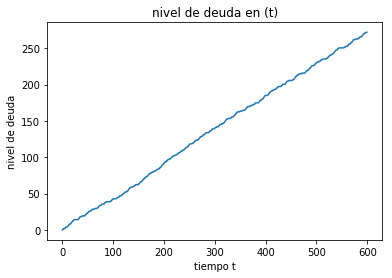

In [16]:
fig = plt.figure()
plt.xlabel('tiempo t')
plt.ylabel('nivel de deuda')
plt.plot(contador_periodos, dt)
plt.title("nivel de deuda en (t)");

Armamos un vector del tipo de cambio fijo otro para el precio local.

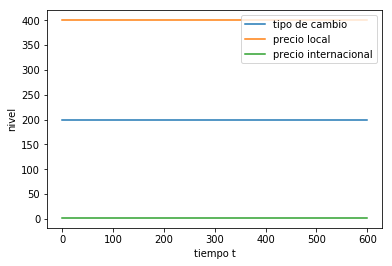

In [15]:
st = [200]*periodos
p_loc = [] #lista que va a contener los valores del precio local para cada periodo
i_loc = [] #lista que va a contener los valores de la tasa de interes local para cada peiodo
for i in contador_periodos:
    p_loc.append(p_int[i]*st[i]) #agregamos el valor del precio local para ese periodo
    i_loc.append(i_int)#lo mismo para la tasa de interes internacional

#ploteamos el precio local, el precio internacioal y el tipo de cambio 
plt.plot(contador_periodos, st, label='tipo de cambio')
plt.plot(contador_periodos, p_loc, label='precio local')
plt.plot(contador_periodos, p_int, label='precio internacional')
plt.xlabel('tiempo t')
plt.ylabel('nivel')
plt.legend();

**FOWARD PREMIUM**

Calculamos la funcion kt para cada periodo, una vez calculada la funcion kt podemos calcular la probabilidad de la corrida pi_t. Beta hay que calibrarlo, alpha tambien

In [17]:
beta = 1
alpha = 0.02
kt = []
pi_t=[]
for i in contador_periodos:
    kt.append(beta*st[i] -((alpha*mu[i])/beta) - dt[i] - mu[i] + (1/lambdaa))
for i in contador_periodos:
    pi_t.append(math.exp(-lambdaa*kt[i]))
for i in contador_periodos:
    if pi_t[i]>= 1:
        pi_t[i]= 1

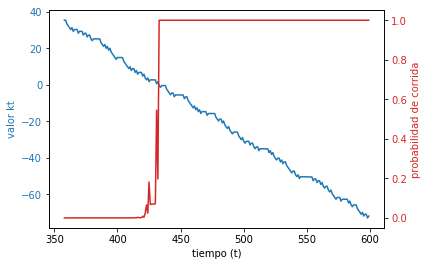

In [9]:
#calculo la "ventana" de t a graficar
cota_inf = 0
for i in contador_periodos:
    if kt[i] <=10:
        cota_inf = i-50
        break
contador_periodos_graph = contador_periodos[cota_inf:periodos]
kt_graph = kt[cota_inf:periodos]
pi_t_graph = pi_t[cota_inf:periodos]


fig, ax1 = plt.subplots()
#grafico para kt
color = 'tab:blue'
ax1.set_xlabel('tiempo (t)')
ax1.set_ylabel('valor kt', color=color)
ax1.plot(contador_periodos_graph, kt_graph, color = color)
ax1.tick_params(axis='y', labelcolor=color)

#grafico para pi_t
color = 'tab:red'
ax2 = ax1.twinx()
ax2.set_ylabel('probabilidad de corrida', color=color)
ax2.plot(contador_periodos_graph, pi_t_graph,color=color)
ax2.tick_params(axis='y', labelcolor=color);

Podemos ver que a mientras mas se acerca kt a 0, la probabilidad de una corrida aumenta. Esto se debe a que la integral de la probabilidad de corrida tiene como bound inferior a kt. Cuando kt llega a 0, la integral ya suma un area de 1 por eso el "salto" de la probabilidad cuando kt cruza 0.

Calculamos el tipo de cambio esperado mañana

In [10]:
esp_st_mañana = []
for i in contador_periodos: 
    esp_st_mañana.append(((1-pi_t[i])*st[i])+((pi_t[i]/beta)*((alpha*mu[i])/beta + dt[i] + mu[i] + kt[i]))) 
#print(esp_st_mañana)

Calculamos cotas para hacer un mejor grafico

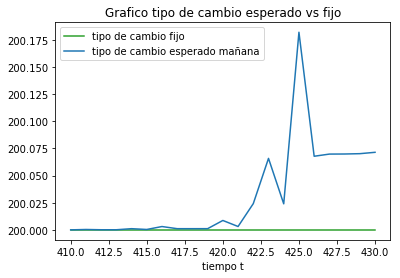

In [19]:
cota_inferior = 0 
cota_sup = 0
for i in contador_periodos:
    if esp_st_mañana[i] >=200.1:
        cota_inferior = i-15
        break
for i in contador_periodos:
    if esp_st_mañana[i] >=200.2:
        cota_sup = i
        break
esp_st_mañana_graph = esp_st_mañana[cota_inferior:cota_sup]
contador_periodos_graph = contador_periodos[cota_inferior:cota_sup]
st_graph = st[cota_inferior:cota_sup]


plt.plot(contador_periodos_graph, st_graph, label='tipo de cambio fijo', color = 'tab:green')
plt.plot(contador_periodos_graph, esp_st_mañana_graph, label='tipo de cambio esperado mañana',color = 'tab:blue')
plt.xlabel('tiempo t')
plt.title("Grafico tipo de cambio esperado vs fijo")
plt.legend();

Calculamos el Foward Premium para cada periodo T

In [23]:
foward_premium = []        
for i in contador_periodos:
    foward_premium.append((math.exp(-lambdaa*kt[i]))/beta*lambdaa)

Graficamos foward premium contra dt

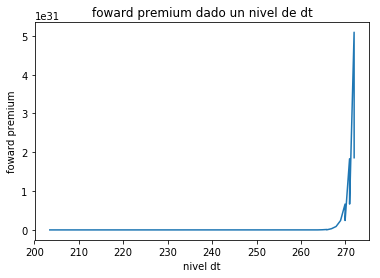

In [28]:
cota_inf = 0
for i in contador_periodos:
    if (foward_premium[i+1]-foward_premium[i])>100:
        cota_inf = i 
        break
foward_premium_plot = foward_premium[cota_inf:periodos]
dt_graph = dt[cota_inf:periodos]
plt.plot(dt_graph, foward_premium_plot)
plt.xlabel('nivel dt')
plt.ylabel('foward premium')
plt.title('foward premium dado un nivel de dt');